## 5. Basic Ephys

This notebook can be run simultaneously with Notebook `2.DecodingPosPreprocessing`.

This notebook specifies electrodes with cells. This information will be used in all ephys processing tables. In addition it will:
1. Specify sort time intervals. Table involved: 
2. Remove artifact. Table involved: `ArtifactRemovedIntervalList` and others
3. Obtain spikes by simple threshold crossing. Table involved: `SortGroup` and `SpikeSortingRecording`

Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
#import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,)
#import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# Shijie's functions
from spyglass.shijiegu.ephysProcessingHelpers import (set_reference, insert_lick_artifact, insert_SortInterval)

[2025-04-10 09:02:24,718][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-10 09:02:24,801][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
nwb_file_name = 'molly20220420.nwb'
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [4]:
# set the list of tetrodes to use for sorting
# NOTE: electrode group name is 0-based, need to subtract 1 from tetrode number

canula_1_tet_list = np.array([1,3,4,7,8,10,11,13,16,18,19,25,26,28 ]) - 1
canula_2_tet_list = np.array([35,38,40,41,42,47,51,53,54,61,62]) - 1
all_tet_list = np.concatenate([canula_1_tet_list,canula_2_tet_list])
all_tet_list

array([ 0,  2,  3,  6,  7,  9, 10, 12, 15, 17, 18, 24, 25, 27, 34, 37, 39,
       40, 41, 46, 50, 52, 53, 60, 61])

### 1.specify what tetrodes to sort: ```SortGroup```

In [5]:
Electrode() & {'nwb_file_name' : nwb_copy_file_name} 

*nwb_file_name *electrode_gro *electrode_id  probe_id       probe_shank    probe_electrod region_id     name     original_refer x       y       z       filtering     impedance     bad_channel    x_warped     y_warped     z_warped     contacts    
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------+ +------------+ +-----+ +-----+ +-----+ +-----------+ +-----------+ +------------+ +----------+ +----------+ +----------+ +----------+
molly20220420_ 0              0              tetrode_12.5   0              0              19            0        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 0              1              tetrode_12.5   0              1              19            1        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 0              2              tetrode_12.5   0              2              19            2        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 0              3              tetrode_12.5   0              3              19            3        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 1              4              tetrode_12.5   0              0              19            4        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 1              5              tetrode_12.5   0              1              19            5        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 1              6              tetrode_12.5   0              2              19            6        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 1              7              tetrode_12.5   0              3              19            7        64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 10             40             tetrode_12.5   0              0              19            40       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 10             41             tetrode_12.5   0              1              19            41       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 10             42             tetrode_12.5   0              2              19            42       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 10             43             tetrode_12.5   0              3              19            43       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
   ...
 (Total: 256)

In [6]:
# check if dead channels are removed
from spyglass.common import Electrode
print('good electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} & {'bad_channel' : 'False'}).fetch('electrode_group_name').shape)
print('all electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} ).fetch('electrode_group_name').shape)

# find the reference for the 1st canula and the 2nd canula

canula_1_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 0}).fetch('original_reference_electrode')[0]
print('original (in config) canula 1 ref',canula_1_ref)
#canula_2_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
#       {'electrode_id' : 255}).fetch('original_reference_electrode')[0]

canula_2_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 127}).fetch('original_reference_electrode')[0]
print('original (in config) canula 2 ref',canula_2_ref)

good electrodes (254,)
all electrodes (256,)
original (in config) canula 1 ref 64
original (in config) canula 2 ref 64


#### Are they the same as your intended references? If not do the following 2 cells. If yes, skip.

In [7]:
(Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : 17-1}&
        {'bad_channel' : 'False'})

*nwb_file_name *electrode_gro *electrode_id  probe_id       probe_shank    probe_electrod region_id     name     original_refer x       y       z       filtering     impedance     bad_channel    x_warped     y_warped     z_warped     contacts    
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------+ +------------+ +-----+ +-----+ +-----+ +-----------+ +-----------+ +------------+ +----------+ +----------+ +----------+ +----------+
molly20220420_ 16             64             tetrode_12.5   0              0              19            64       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 16             65             tetrode_12.5   0              1              19            65       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 16             66             tetrode_12.5   0              2              19            66       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220420_ 16             67             tetrode_12.5   0              3              19            67       64             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
 (Total: 4)

In [46]:
(Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : 49-1})

*nwb_file_name *electrode_gro *electrode_id  probe_id       probe_shank    probe_electrod region_id     name     original_refer x       y       z       filtering     impedance     bad_channel    x_warped     y_warped     z_warped     contacts    
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------+ +------------+ +-----+ +-----+ +-----+ +-----------+ +-----------+ +------------+ +----------+ +----------+ +----------+ +----------+
molly20220418_ 48             192            tetrode_12.5   0              0              19            192      193            0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220418_ 48             193            tetrode_12.5   0              1              19            193      193            0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
molly20220418_ 48             194            tetrode_12.5   0              2              19            194      193            0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
molly20220418_ 48             195            tetrode_12.5   0              3              19            195      193            0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
 (Total: 4)

In [116]:
# set reference here:
canula_1_ref = 64
canula_2_ref = 193

### insert into SortGroup

In [117]:
set_reference(nwb_copy_file_name, canula_1_tet_list, canula_1_ref)
set_reference(nwb_copy_file_name, canula_2_tet_list, canula_2_ref)

### Include two more tetrodes sort group for lick artifact

In [118]:
insert_lick_artifact(nwb_copy_file_name, canula_1_tet_list, canula_1_ref, 100)
insert_lick_artifact(nwb_copy_file_name, canula_2_tet_list, canula_2_ref, 101)

In [119]:
ids = (SortGroup & {'nwb_file_name' : nwb_copy_file_name}).fetch("sort_group_id")
refs = (SortGroup & {'nwb_file_name' : nwb_copy_file_name}).fetch("sort_reference_electrode_id")
for i in range(len(ids)):
    print(f"electrode ID {ids[i]}: Ref {refs[i]}")

electrode ID 0: Ref 64
electrode ID 1: Ref 64
electrode ID 2: Ref 64
electrode ID 3: Ref 64
electrode ID 4: Ref 64
electrode ID 5: Ref 64
electrode ID 6: Ref 64
electrode ID 7: Ref 64
electrode ID 8: Ref 64
electrode ID 9: Ref 64
electrode ID 10: Ref 64
electrode ID 11: Ref 64
electrode ID 12: Ref 64
electrode ID 13: Ref 64
electrode ID 14: Ref 64
electrode ID 15: Ref 64
electrode ID 16: Ref 64
electrode ID 17: Ref 64
electrode ID 18: Ref 64
electrode ID 19: Ref 64
electrode ID 20: Ref 64
electrode ID 21: Ref 64
electrode ID 22: Ref 64
electrode ID 23: Ref 64
electrode ID 24: Ref 64
electrode ID 25: Ref 64
electrode ID 26: Ref 64
electrode ID 27: Ref 64
electrode ID 28: Ref 64
electrode ID 29: Ref 64
electrode ID 30: Ref 64
electrode ID 31: Ref 64
electrode ID 32: Ref 193
electrode ID 33: Ref 193
electrode ID 34: Ref 193
electrode ID 35: Ref 193
electrode ID 36: Ref 193
electrode ID 37: Ref 193
electrode ID 38: Ref 193
electrode ID 39: Ref 193
electrode ID 40: Ref 193
electrode ID 41: 

Electrode ID 100 and 101 should have ref electrodes for the 2 cannulas.

### 2. sort intervals: ```SortInterval```,```IntervalList```,```SpikeSortingRecordingSelection```

In [16]:
session_interval = insert_SortInterval(nwb_copy_file_name)

In [17]:
print(session_interval)

['01_Seq2Sleep1' '02_Seq2Session1' '03_Seq2Sleep2' '04_Seq2Session2'
 '05_Seq2Sleep3' '06_Seq2Session3' '07_Seq2Sleep4' '08_Seq2Session4'
 '09_Seq2Sleep5' '10_Seq2Session5' '11_Seq2Sleep6' '12_Seq2Session6'
 '13_Seq2Sleep7']


In [8]:
SortInterval & {'nwb_file_name' : nwb_copy_file_name}

*nwb_file_name *sort_interval sort_inter
+------------+ +------------+ +--------+
molly20220420_ 01_Seq2Sleep1  =BLOB=    
molly20220420_ 02_Seq2Session =BLOB=    
molly20220420_ 03_Seq2Sleep2  =BLOB=    
molly20220420_ 04_Seq2Session =BLOB=    
molly20220420_ 05_Seq2Sleep3  =BLOB=    
molly20220420_ 06_Seq2Session =BLOB=    
molly20220420_ 07_Seq2Sleep4  =BLOB=    
molly20220420_ 08_Seq2Session =BLOB=    
molly20220420_ 09_Seq2Sleep5  =BLOB=    
molly20220420_ 10_Seq2Session =BLOB=    
molly20220420_ 11_Seq2Sleep6  =BLOB=    
molly20220420_ 12_Seq2Session =BLOB=    
   ...
 (Total: 14)

In [123]:
def sort_selection(tetrode_sort_interval_name):
    tetrode=tetrode_sort_interval_name[0]
    sort_interval_name=tetrode_sort_interval_name[1]
    print('create recording for tet',str(tetrode))  
    key = dict()
    key['nwb_file_name'] = nwb_copy_file_name
    key['sort_group_id'] = tetrode
    key['sort_interval_name'] = sort_interval_name
    key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
    key['interval_list_name'] = sort_interval_name
    key['team_name'] = 'SequenceTask'

    ssr_key1 = key

    SpikeSortingRecordingSelection.insert1(ssr_key1, skip_duplicates=True)
    SpikeSortingRecording.populate(ssr_key1)

In [ ]:
for t in all_tet_list:
    for s in session_interval:
        sort_selection((t,s))

for t in [100,101]:
    for s in session_interval:
        sort_selection((t,s))

create recording for tet 0
write_binary_recording with n_jobs = 8 and chunk_size = 299593


write_binary_recording:   0%|          | 0/203 [00:00<?, ?it/s]

create recording for tet 0
create recording for tet 0
write_binary_recording with n_jobs = 8 and chunk_size = 299593


write_binary_recording:   0%|          | 0/173 [00:00<?, ?it/s]

create recording for tet 0
write_binary_recording with n_jobs = 8 and chunk_size = 299593


write_binary_recording:   0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
#sort_selection((t,s))

In [134]:
#(SpikeSortingRecordingSelection() & {'nwb_file_name' : nwb_copy_file_name}).delete()

Check all jobs are finished.

In [11]:
for tet in all_tet_list:
    key = {'nwb_file_name' : nwb_copy_file_name,
           "sort_group_id": tet}
    assert len(SpikeSortingRecordingSelection & key) == len(SpikeSortingRecording & key)

for tet in [100, 101]:
    key = {'nwb_file_name' : nwb_copy_file_name,
           "sort_group_id": tet}
    assert len(SpikeSortingRecordingSelection & key) == len(SpikeSortingRecording & key)

In [12]:
tet

101

#### If the `SpikeSortingRecording` table is filled, jump to Artifact detection section.
If run only one tetrode

In [23]:
tetrode=100
sort_interval_name='04_Seq2Session2'
sort_selection([tetrode,sort_interval_name])

tetrode=101
sort_interval_name='04_Seq2Session2'
sort_selection([tetrode,sort_interval_name])

create recording for tet 100


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

OSError: [Errno 39] Directory not empty: '/stelmo/nwb/recording/eliot20221018_.nwb_04_Seq2Session2_100_franklab_tetrode_hippocampus'

In [ ]:
#(SpikeSortingRecordingSelection & {'nwb_file_name' : "molly20220418_.nwb"}).delete()

In [ ]:
#SpikeSortingRecording & {'nwb_file_name' : "molly20220418_.nwb",'sort_group_id':100}

### 3. artifact detection

In [14]:
def artifact_selection(tetrode_sort_interval_name):
    tetrode=tetrode_sort_interval_name[0]
    sort_interval_name=tetrode_sort_interval_name[1]
    artifact_params_name=tetrode_sort_interval_name[2]
    print('artifact for tet',str(tetrode))  

    key = dict()
    key['nwb_file_name'] = nwb_copy_file_name
    key['sort_group_id'] = tetrode
    key['sort_interval_name'] = sort_interval_name
    key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
    key['team_name'] = 'SequenceTask'
    key['artifact_params_name'] = artifact_params_name

    ssr_key1 = key

    ArtifactDetectionSelection.insert1(ssr_key1, skip_duplicates=True)
    ArtifactDetection.populate([(ArtifactDetectionSelection & ssr_key1).proj()])

In [18]:
selections_100101=[]
for t in [100,101]:
    for s in session_interval:
        artifact_selection((t,s,'ampl_100_prop_05_2ms'))
        #selections_100101.append((t,s,'ampl_100_prop_05_2ms'))
#selections_100101

artifact for tet 100


[09:04:07][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/182 [00:00<?, ?it/s]

artifact for tet 100


[09:04:29][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/220 [00:00<?, ?it/s]

artifact for tet 100


[09:04:57][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/232 [00:00<?, ?it/s]

artifact for tet 100


[09:05:25][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/225 [00:00<?, ?it/s]

artifact for tet 100


[09:05:51][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/182 [00:00<?, ?it/s]

[09:06:09][WARNING] Spyglass: No artifacts detected.


artifact for tet 100


[09:06:13][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/231 [00:00<?, ?it/s]

artifact for tet 100


[09:06:38][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/187 [00:00<?, ?it/s]

artifact for tet 100


[09:07:01][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/238 [00:00<?, ?it/s]

artifact for tet 100


[09:07:30][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/242 [00:00<?, ?it/s]

[09:07:56][WARNING] Spyglass: No artifacts detected.


artifact for tet 100


[09:08:02][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/258 [00:00<?, ?it/s]

artifact for tet 100


[09:08:38][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/278 [00:00<?, ?it/s]

artifact for tet 100


[09:09:13][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/236 [00:00<?, ?it/s]

artifact for tet 100


[09:09:40][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/185 [00:00<?, ?it/s]

artifact for tet 101


[09:10:03][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/182 [00:00<?, ?it/s]

artifact for tet 101


[09:10:24][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/220 [00:00<?, ?it/s]

artifact for tet 101


[09:10:52][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/232 [00:00<?, ?it/s]

[09:11:17][WARNING] Spyglass: No artifacts detected.


artifact for tet 101


[09:11:21][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/225 [00:00<?, ?it/s]

artifact for tet 101


[09:11:47][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/182 [00:00<?, ?it/s]

[09:12:07][WARNING] Spyglass: No artifacts detected.


artifact for tet 101


[09:12:12][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/231 [00:00<?, ?it/s]

artifact for tet 101


[09:12:40][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/187 [00:00<?, ?it/s]

artifact for tet 101


[09:13:03][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/238 [00:00<?, ?it/s]

artifact for tet 101


[09:13:32][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/242 [00:00<?, ?it/s]

artifact for tet 101


[09:14:01][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/258 [00:00<?, ?it/s]

artifact for tet 101


[09:14:34][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/278 [00:00<?, ?it/s]

artifact for tet 101


[09:15:05][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/236 [00:00<?, ?it/s]

artifact for tet 101


[09:15:31][INFO] Spyglass: using 4 jobs...


detect_artifact_frames:   0%|          | 0/185 [00:00<?, ?it/s]

In [111]:
#(ArtifactDetectionSelection & {'nwb_file_name' : nwb_copy_file_name}).delete()

In [13]:
(ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name} )

*artifact_remo nwb_file_name  sort_group_id  sort_interval_ preproc_params team_name     artifact_param artifact_r artifact_t
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +--------+ +--------+

 (Total: 0)

# End here

In [38]:
#dj.ERD(ArtifactDetectionSelection)-3+3

In [23]:
"""
param_dict = dict()
param_dict['zscore_thresh'] = None
param_dict['amplitude_thresh'] = 100
param_dict['proportion_above_thresh'] = 0.5
param_dict['removal_window_ms'] = 2
artifact_params_name='ampl_100_prop_05_2ms'
ArtifactDetectionParameters.insert1({'artifact_params_name': artifact_params_name,
                                     'artifact_params': param_dict}, skip_duplicates=True)
"""

### 4. plot data from recording

In [39]:
import spikeinterface as si

tetrode=101
sort_group = 101
session_name='02_Seq2Session1'
sort_interval_name='02_Seq2Session1'

# get session start time
session_start_end=(IntervalList & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':session_name}).fetch1('valid_times')

# obtain neural data
recording_path = (SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name,
                                           'sort_interval_name' : sort_interval_name,
                                           'sort_group_id' : tetrode}).fetch1('recording_path')
recording = si.load_extractor(recording_path)
if recording.get_num_segments() > 1 and isinstance(recording, si.AppendSegmentRecording):
    recording = si.concatenate_recordings(recording.recording_list)
elif recording.get_num_segments() > 1 and isinstance(recording, si.BinaryRecordingExtractor):
    recording = si.concatenate_recordings([recording])

valid_timestamps = SpikeSortingRecording._get_recording_timestamps(recording)

# ripple band data
ripple_eseries=(LFPBand() & {'nwb_file_name' : nwb_copy_file_name}).fetch_nwb()[0]['filtered_data']
ripple_thresh=2*np.std(ripple_eseries.data)

# artifact time
artifact_plot_times = (ArtifactDetection 
                       & {'nwb_file_name' : nwb_copy_file_name} 
                       & {'sort_interval_name' : sort_interval_name} 
                       & {'sort_group_id' : sort_group}
                       & {'artifact_params_name': artifact_params_name}).fetch1('artifact_times')

IndexError: list index out of range

76


Text(0.5, 1.0, 'percentage of electrode: 0.8392857142857143 \n min into session 1.9393630146980285')

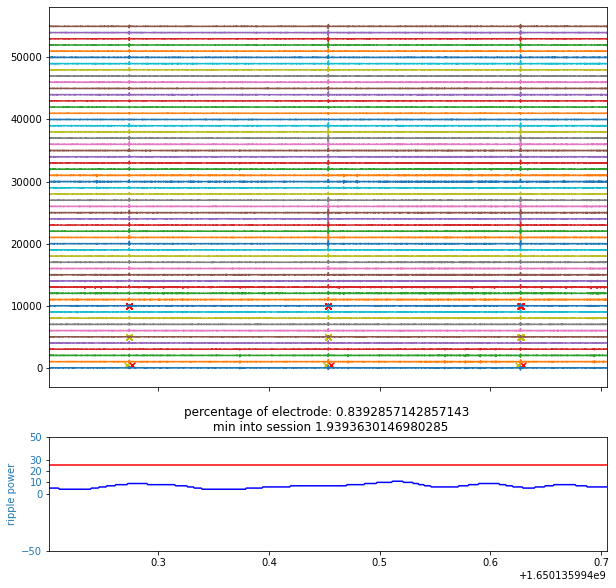

In [290]:
#artifact_num = 22
artifact_num=artifact_num+2
print(artifact_num)

plottimes = [artifact_plot_times[artifact_num][0]-0.25, artifact_plot_times[artifact_num][1]+0.25]
#plottimes = [artifact_plot_times[artifact_num][0]-0.1, artifact_plot_times[artifact_num][1]+0.1]
#plottimes = [artifact_plot_times[artifact_num][0]-1, artifact_plot_times[artifact_num][1]+1]

orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()
neural_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1]+1)
time_into_recording=(np.mean(artifact_plot_times[artifact_num])-session_start_end[0][0])/60

lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

fig, axes = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [10,3]},sharex=True,figsize=(10,10))
numtrodes=np.shape(neural_data)[1]
for i in range(numtrodes):
    #plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
    axes[0].plot(valid_timestamps[orig_time_ind], neural_data[:,i]+i*1000)

color = 'tab:blue'
axes[1].set_ylabel('ripple power', color=color)  # we already handled the x-label with ax1
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], ripple_smooth[lfp_time_ind], 'b-')
axes[1].set_ylim(np.array([-50,50]))
axes[1].plot(plottimes,[ripple_thresh,ripple_thresh],'r-')
axes[1].set_yticks(np.array([-50,0,10,20,30,50]))
axes[1].tick_params(axis='y', labelcolor=color)

# times when more than 12 tetrodes of more than >200 uV
largenum=np.sum(np.abs(neural_data)>200,axis=1)
artifact_plot_times_=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

largenum=np.sum(np.abs(neural_data)>150,axis=1)
artifact_plot_times_2=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

axes[0].scatter(artifact_plot_times_, np.repeat(5000,artifact_plot_times_.shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times_2, np.repeat(10000,artifact_plot_times_2.shape[0]),marker='x',color='r')

# start and end time of artifact
axes[0].scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])
plt.title('percentage of electrode: '+str(np.max(largenum)/numtrodes)+' \n min into session '+str(time_into_recording))

## More plotting

In [277]:
def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition.astype(int))
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        print('condition 0')
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        print('condition 1')
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx

In [362]:
ripple_thresh=2*np.std(ripple_eseries.data[:,0])
ripple_thresh

24.940082302614492

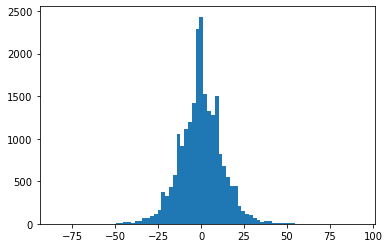

In [383]:
plt.hist(ripple_eseries.data[::100],bins=80);

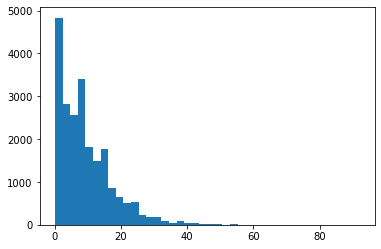

In [382]:
plt.hist(np.abs(ripple_eseries.data[::100]),bins=80);

In [308]:
from scipy.ndimage.filters import gaussian_filter1d

ripple_smooth=gaussian_filter1d(np.array(np.abs(ripple_eseries.data[:,0])),15,mode='constant')

In [363]:
ripple_intervals=contiguous_regions(ripple_smooth>=ripple_thresh) #index

In [365]:
ripple_times=ripple_intervals.copy().astype('float')
ripple_times[:,0]=ripple_eseries.timestamps[ripple_intervals[:,0]]
ripple_times[:,1]=ripple_eseries.timestamps[ripple_intervals[:,1]-1]
ripple_ind=np.diff(ripple_times,axis=1)>=0.015
ripple_times=ripple_times[ripple_ind.ravel()]
ripple_intervals=ripple_intervals[ripple_ind.ravel()]
#ripple_times

In [366]:
np.shape(ripple_times) #20

(152, 2)

22
[1650136378.3928502, 1650136378.9278505]
[]


Text(0.5, 1.0, 'percentage of electrode: 0.10714285714285714 \n min into session 1.9393630146980285')

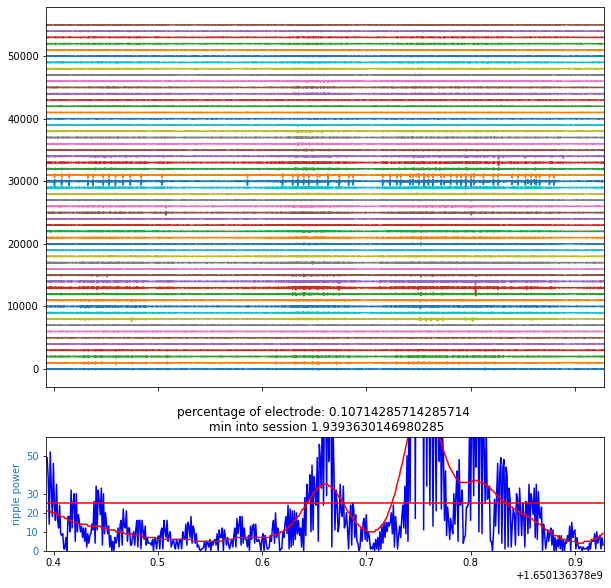

In [396]:
ripple_num=22
#ripple_num=ripple_num+1
print(ripple_num)

plottimes = [ripple_times[ripple_num][0]-0.25, ripple_times[ripple_num][1]+0.25]
print(plottimes)
#plottimes = [ripple_times[ripple_num][0], ripple_times[ripple_num][1]]
#plottimes = [artifact_plot_times[artifact_num][0]-1, artifact_plot_times[artifact_num][1]+1]

orig_time_ind = np.argwhere(np.logical_and(valid_timestamps >= plottimes[0], valid_timestamps < plottimes[1])).ravel()
neural_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1]+1)
time_into_recording=(np.mean(artifact_plot_times[artifact_num])-session_start_end[0][0])/60

lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

fig, axes = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [10,3]},sharex=True,figsize=(10,10))
numtrodes=np.shape(neural_data)[1]
for i in range(numtrodes):
    axes[0].plot(valid_timestamps[orig_time_ind], neural_data[:,i]+i*1000)

color = 'tab:blue'
axes[1].set_ylabel('ripple power', color=color)  # we already handled the x-label with ax1
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], np.abs(ripple_eseries.data[lfp_time_ind,0]), 'b-')
axes[1].plot(ripple_eseries.timestamps[lfp_time_ind], np.abs(ripple_smooth[lfp_time_ind]), 'r-')
axes[1].set_ylim(np.array([0,60]))
axes[1].plot(plottimes,[ripple_thresh,ripple_thresh],'r-')
axes[1].set_yticks(np.array([0,10,20,30,50]))
axes[1].tick_params(axis='y', labelcolor=color)

# times when more than 12 tetrodes of more than >200 uV
largenum=np.sum(np.abs(neural_data)>200,axis=1)
artifact_plot_times_=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]
print(artifact_plot_times_)

largenum=np.sum(np.abs(neural_data)>150,axis=1)
artifact_plot_times_2=valid_timestamps[orig_time_ind][np.argwhere(largenum>=20).ravel()]

axes[0].scatter(artifact_plot_times_, np.repeat(5000,artifact_plot_times_.shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times_2, np.repeat(10000,artifact_plot_times_2.shape[0]),marker='x',color='r')

# start and end time of artifact
axes[0].scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
axes[0].scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])
plt.title('percentage of electrode: '+str(np.max(largenum)/numtrodes)+' \n min into session '+str(time_into_recording))

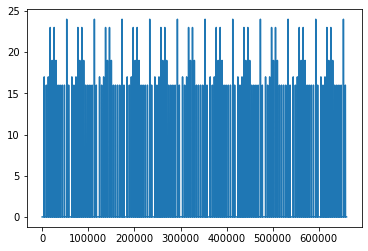

In [169]:
plt.plot(np.sum(eseries_data[orig_time_ind,:]>200,axis=1))

(1650141898.4752865, 1650141898.4802532)

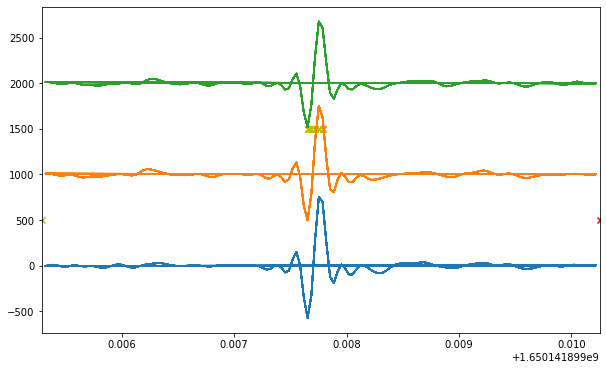

In [192]:
plt.figure(figsize=(10,6))
for i in [25,26,27]:
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+(i-25)*1000)
    
plt.scatter(artifact_plot_times_, np.repeat(1500,artifact_plot_times_.shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [142]:
artifact_ind=np.digitize(artifact_time,np.sort(valid_timestamps))

KeyboardInterrupt: 

In [ ]:
#(SortInterval & {'nwb_file_name' : nwb_copy_file_name,'sort_interval_name' : 'spikesort_maze'}).fetch('sort_interval')[0][6,0]

In [71]:
artifact_num = 3
plottimes = [artifact_plot_times[artifact_num][0] - 0.005, artifact_plot_times[artifact_num][1] + 0.005]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

In [64]:
#eseries_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1])

In [127]:
np.shape(eseries_data)

(4213342473, 28)

In [128]:
np.shape(valid_timestamps)

(4213342473,)

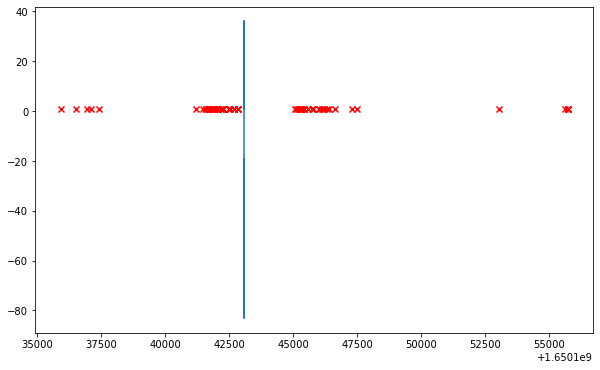

In [130]:
plt.figure(figsize=(10,6))
plt.plot(valid_timestamps[:1000],eseries_data[:1000,0])
plt.scatter(artifact_time,np.ones(np.shape(artifact_time)),marker='x',color='r')

(1650137079.670135, 1650137079.6852353)

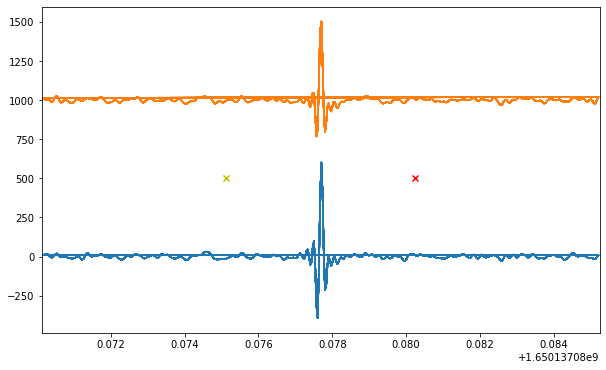

In [72]:
plt.figure(figsize=(10,6))
for i in range(2):
#for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [137]:
plottimes

[1650136504.256454, 1650136504.361554]

(1650136504.256454, 1650136504.361554)

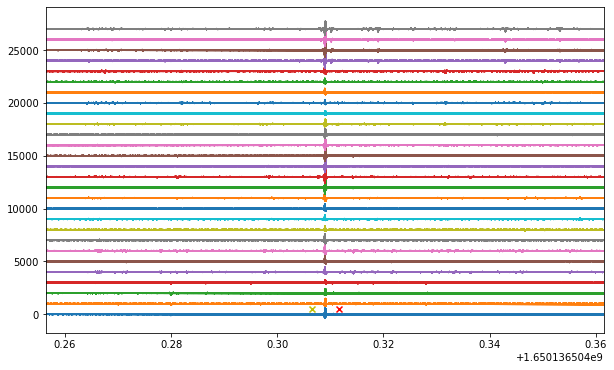

In [135]:
artifact_num = 1
plottimes = [artifact_plot_times[artifact_num][0] - .05, artifact_plot_times[artifact_num][1] + .05]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

plt.figure(figsize=(10,6))
for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])